In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from time import time
#import plotly.plotly as py
#import plotly.graph_objs as go
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
import folium
%matplotlib inline
sns.set_style("darkgrid")

<h1>Funções e Variáveis Auxiliares</h1>

In [2]:
dataset = pd.read_csv('testdata.csv')

In [3]:
# Starting from Sunday, as day 1 of july
week_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekend = ['Sunday', 'Saturday']
categories = dataset['categoria'].unique()
week_days_color = {
    'Sunday': '#803315',
    'Monday': '#3D1255',
    'Tuesday': '#7887AB',
    'Wednesday': '#216A12',
    'Thursday': '#7E7F15',
    'Friday': '#AA8639',
    'Saturday': '#661141'
}
correct_day_day_of_week = {str(i).zfill(2): week_days[(i-1)%7] for i in range(1, 32)}

In [4]:
dataset.head()

,user,latitude,longitude,date,day_of_week,hour,categoria,timestamp
0,User_3401,-26.489503,-49.028018,2018-07-08,Saturday,18,bakery,1531604419436
1,User_539,-14.457400,-46.433148,2018-07-08,Sunday,7,restaurant,1531650749377
2,User_789,-8.903859,-36.487485,2018-07-08,Saturday,9,night_club,1531571345816
3,User_2814,-22.823960,-43.012243,2018-07-08,Saturday,22,store,1531619273330
4,User_3432,-24.949576,-53.488507,2018-07-08,Sunday,3,restaurant,1531634482205


<h1>Análise dos Dados</h1>
<p>Inicialmente podemos analisar o dataset buscando valores únicos que podem retornar algum insight.</p>

<h2>Limpando o Dataset</h2>
<p>Através de algumas análises de colunas, notei que alguns valores são irelevantes:</p>
<ul>
    <li>Posso substituir a coluna de data por uma só contendo os dias do mês. Todas as datas são do mês 7</li>
    <li>Timestamp é irelevante dado que a tabela já contém dia, mês, ano, dia da semana e hora. A única relevancia seria especificar ainda mais além do que já é dado. Além disso o timestamp não está bem formatado e, tentando corrigir, as datas não batem com o que é dado nas outras colunas</li>
    <li>Como a base de dados foi completamente aleatorizada, alguns dias possuem mais de um dia da semana. Para isso eu mapeei todos os dias da semana corretamente no dicionário <b>correct_day_day_of_week</b> e usarei o mesmo para consertar a base.</li>
</ul>

In [5]:
curr_timestamp = time()
first_timestamp_ds = dataset['timestamp'][0]
print('Comparando Timestamps:')
print('%f\n%.d'%(curr_timestamp, first_timestamp_ds))

Comparando Timestamps:
1532473842.155272
1531604419436


<p>Comparando o tamanho dos dois notei que o timestamp do dataset não possui decimal, porém é 4 dígitos maior do que um timestamp correto. Deduzi que esses dígitos a mais seria decimal. Então consertei e comparei a data com o novo timestamp e a data presente no dataset:</p>

In [6]:
# for _, row in dataset[['hour','date','timestamp']].iterrows():
#     datetime_ts = dt.utcfromtimestamp(row['timestamp']/1000)
#     print(datetime_ts.date(), datetime_ts.hour, end = '\t')
#     print(row['date'], row['hour'])

<p>Houve uma inconsistência no dia ou na hora.</p>

In [7]:
dataset = dataset.drop(columns=['timestamp'])

<p>Comparando o dataset completo com aquele filtrando pelo mês 7 de 2018:</p>

In [8]:
dataset[dataset['date'].str.contains(r'2018-07-*.')].shape== dataset.shape

True

In [9]:
dataset['date'] = dataset['date'].apply(lambda date_str: date_str[-2:])
dataset.rename(columns={'date': 'dia'}, inplace=True)

In [10]:
correct_day_day_of_week_col = dataset['dia'].apply(lambda day: correct_day_day_of_week[day])
correct_day_day_of_week_col.name = 'day_of_week'
dataset['day_of_week'] = correct_day_day_of_week_col

<h2>Novo Dataset</h2>
<p>Dataset após todas as mudanças anteriores</p>

In [11]:
dataset.head()

,user,latitude,longitude,dia,day_of_week,hour,categoria
0,User_3401,-26.489503,-49.028018,08,Sunday,18,bakery
1,User_539,-14.457400,-46.433148,08,Sunday,7,restaurant
2,User_789,-8.903859,-36.487485,08,Sunday,9,night_club
3,User_2814,-22.823960,-43.012243,08,Sunday,22,store
4,User_3432,-24.949576,-53.488507,08,Sunday,3,restaurant


<h2>Analisando Atributos Isoladamente</h2>
<p>Em uma primeira passada pela base de dados podemos extrair várias informações com base nas colunas. O objetivo dessa sessão é tentar visualizar o máximo de informação de cada coluna.</p>

<h3>Day of Week</h3>
<p>Analisando os dias da semana é possível discutir qual o melhor dia da semana para se vincular uma campanha.</p>
<p style="color:red">OBS: O dia 15 deve ser desconsiderado, dado que ele é o recomeço de uma semana, sendo o único valor da terceira semana de Julho.</p>

In [12]:
count_day_of_week = dataset[dataset['dia'] != '15']['day_of_week'].value_counts().reindex(week_days)
count_day_of_week

Sunday       3248
Monday       3946
Tuesday      4477
Wednesday    4500
Thursday     4735
Friday       4542
Saturday     4187
Name: day_of_week, dtype: int64

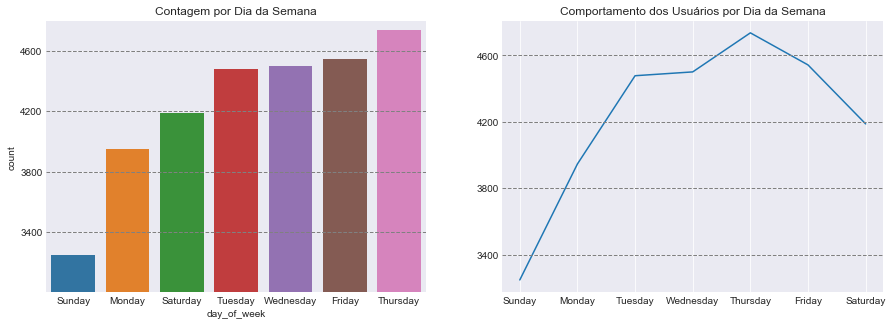

In [13]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title('Contagem por Dia da Semana')
sns.countplot(data=dataset[dataset['dia'] != '15'], 
              x='day_of_week', 
              order=count_day_of_week.sort_values().index, ax=ax1)
yticks_array = [place for place in range(3000, 5000, 400)]
ax1.set_yticks(yticks_array[1:])
for place in yticks_array[1:]:
    ax1.axhline(place, ls='--', c='gray', lw=1)
ax1.set_ylim(ymin=3000, ymax=4800)
ax2 = fig.add_subplot(122)
ax2.set_title('Comportamento dos Usuários por Dia da Semana')
ax2.plot(week_days, count_day_of_week.values)
yticks_array = [place for place in range(3000, 5000, 400)]
ax2.set_yticks(yticks_array[1:])
for place in yticks_array[1:]:
    ax2.axhline(place, ls='--', c='gray', lw=1)
plt.show()

<p>Notamos claramente que o dia com maior movimentação de clientes é Quinta-feira e o dia com menor movimentação é Segunda-Feira, porém os valores entre [Sexta-feira, Terça-feira] acima não variam muito entre si e mantém um valor acima aos 3 últimos. É possível imaginar que os melhores dias para se vincular uma campanha seja Terça, Quarta, Quinta e Sexta.</p>

<h3>Hour</h3>
<p>A partir da coluna de horas é possível saber qual o melhor horário para vincular uma campanha com base no número de usuários presentes em estabelecimentos, assim como os piores horários.</p>

In [14]:
hour_count = dataset['hour'].value_counts().sort_index()
hour_count[:5]

0    450
1    305
2    249
3    229
4    172
Name: hour, dtype: int64

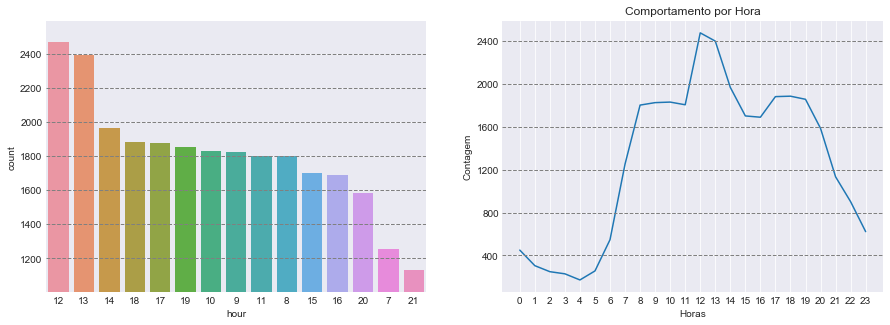

In [15]:
fig = plt.figure(figsize=(15,5))
# First plot
ax1 =fig.add_subplot(121)
sns.countplot(data = dataset, x = 'hour', order=dataset['hour'].value_counts()[:15].index, ax=ax1)
ax1.set_ylim(ymin=1000)
yticks_array = [place for place in range(1000, 2600, 200)]
ax1.set_yticks(yticks_array[1:])
for place in yticks_array[1:]:
    ax1.axhline(place, ls='--', c='gray', lw=1)
# Second plot
ax2 = fig.add_subplot(122)
ax2.set_title('Comportamento por Hora')
ax2.plot(hour_count)
ax2.set_xlabel('Horas')
ax2.set_xticks(list(range(24)))
ax2.set_ylabel('Contagem')
yticks_array = [place for place in range(0, 2800, 400)]
ax2.set_yticks(yticks_array[1:])
for place in yticks_array[1:]:
    ax2.axhline(place, ls='--', c='gray', lw=1)
plt.show()

<p>A partir do gráfico da esquerda vemos quais os horários mais movimentados e, com base nisso, podemos tentar estimar o melhor horário para vincular uma campanha. O gráfico da direita já mostra o comportamento dos usuários por hora do dia, ajudando a entender que, por exemplo, no período do almoço (12-13 horas) há uma maior movimentação de usuários, porém há uma quandidade considerável dos mesmos entre 8 e 19 horas. Dessa forma podemos pensar em vincular campanhas entre 2 ranges de horários:</p>
<ul>
    <li>12-13 horas: Horário de almoço.</li>
    <li>8-19 horas: Horário mais ativo do dia.</li>
</ul>

In [16]:
# Quais são as horas cuja sua contagem é superior a mediana das contagens
hour_count[hour_count > hour_count.median()].keys().sort_values()

Int64Index([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')

<p>A partir do array acima temos uma faixa de horário ideal para rodar um anúncio de promoção.</p>

<h3>Dia da Semana x Hora</h3>
<p>É possível imaginar que, na semana, o fluxo de clientes seja maior em um específico horário pensando, por exemplo, em restaurantes na hora do almoço, ou clientes em shoppings na parte da tarde. Por esses insights que vale a pena investigar o comportamento dos usuários por dia da semana e dividindo entre dias úteis e não.</p>

In [17]:
aux = 'Friday'
def plotLineplotDayWeek(df):
    pass

In [18]:
group_by_day_of_week = dataset.groupby(by='day_of_week')['hour'].value_counts()

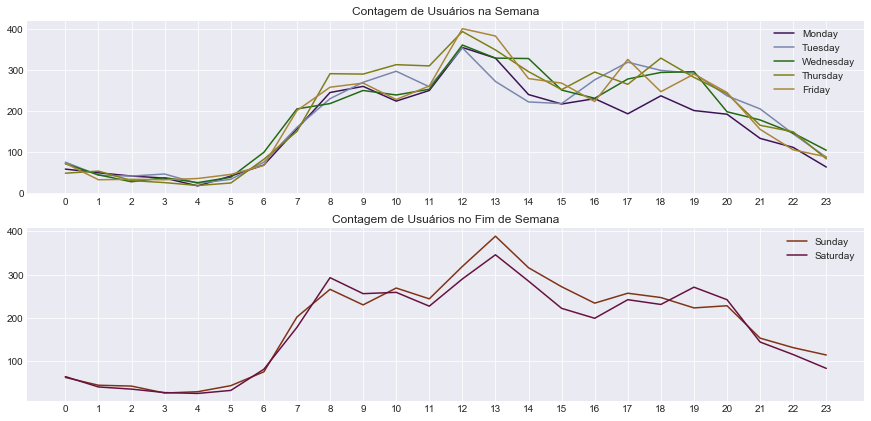

In [19]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.set_title('Contagem de Usuários na Semana')
for week_day in week:
    ax1.plot(group_by_day_of_week[week_day].sort_index(), c = week_days_color[week_day], label=week_day)
ax1.legend()
ax1.set_xticks(list(range(0,24)))
ax2 = fig.add_subplot(212)
ax2.set_title('Contagem de Usuários no Fim de Semana')
for week_day in weekend:
    ax2.plot(group_by_day_of_week[week_day].sort_index(), c = week_days_color[week_day], label=week_day)
ax2.legend()
ax2.set_xticks(list(range(0,24)))
plt.show()

<h4>Plotly</h4>
<p>Utilizando a biblioteca plotly é possível adicionar alguns efeitos como, por exemplo, esconder a linha ao clicar na legenda e adicionar zoom aos gráficos, porém não é possível visualizar o output no github. Segue o snapshot do gráfico:</p>
<img src = 'linechart1.png'></img>
<img src = 'linechart2.png'></img>
<p>Ao executar o código abaixo em um notebook, é possível interagir com o mesmo.</p>

In [20]:
# lines = []
# for week_day in week_days:
#     week_data = group_by_day_of_week[week_day].sort_index()
#     scatter = go.Scatter(x = week_data.index,
#                          y = week_data.values,
#                          name = week_day)
#     lines.append(scatter)
# py.iplot(lines, filename='week_days_by_hour_linechart')

<p>A partir dos gráficos acima podemos notar uma certa semelhança no formato dos mesmos. Porém, ao analisarmos nos fins de semana, vemos que a hora mais movimentada é 13 horas e o "range" de horários aumenta, sendo agora entre 8 e 20 horas. Resta saber que tipo de estabelecimentos são mais visitados.</p>

<h3>Categoria</h3>
<p>A partir da categoria dos estabelecimentos podemos prever qual a categoria mais visitada por clientes, daí vincular propagandas mais direcionadas a esse público.</p>

In [21]:
dataset['categoria'].value_counts()[:5]

restaurant                5826
store                     3461
school                    1728
doctor                    1203
grocery_or_supermarket    1103
Name: categoria, dtype: int64

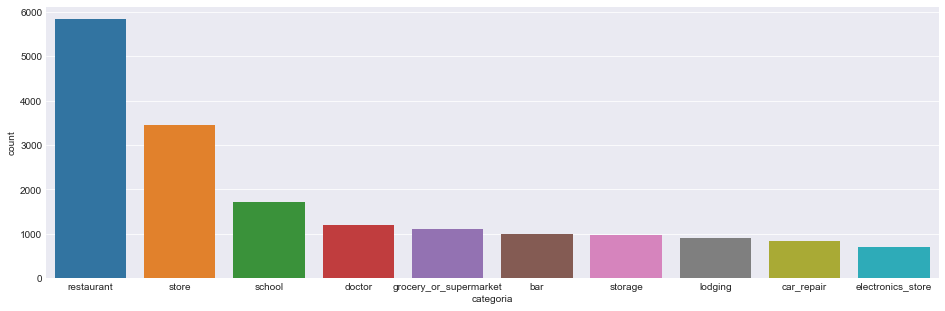

In [22]:
plt.figure(figsize=(16,5))
sns.countplot(data=dataset, x = 'categoria', order=dataset['categoria'].value_counts()[:10].index)
plt.show()

<p>No gráfico anterior temos as 10 categorias mais visitadas por usuários e, mesmo entre essas 10, notamos o destaque para restaurantes. No mês de Julho, restaurantes foram os estabelecimentos mais visitados, sendo visitado quase o dobro de vezes que o segundo colocado, que seriam lojas em geral.</p>

<h3>Categoria x Dia da Semana</h3>
<p><b>OBS: Provavelmente iremos encontrar alguma inconsistência já que os dados foram completamente aleatorizados</b></p>
<p>De acordo com as análises anteriores, um bom pensamento talvez seja analisar como os usuários se comportam em cada dia da semana, então gerei dois métodos:</p>
<ul>
    <li>O primeiro método gera barcharts a partir do agrupamento por dias da semana e contando as entradas de usuários por estabelecimento.</li>
    <li>O segundo método é o oposto do primeiro.</li>
</ul>

In [23]:
category_week = dataset[dataset['day_of_week'].isin(week)]['categoria'].value_counts().sort_values(ascending=False)
category_week['others'] = sum(category_week[11:])
category_week.sort_values(ascending=False, inplace=True)

category_weekend = dataset[dataset['day_of_week'].isin(weekend)]['categoria'].value_counts().sort_values(ascending=False)
category_weekend['others'] = sum(category_weekend[11:])
category_weekend.sort_values(ascending=False, inplace=True)

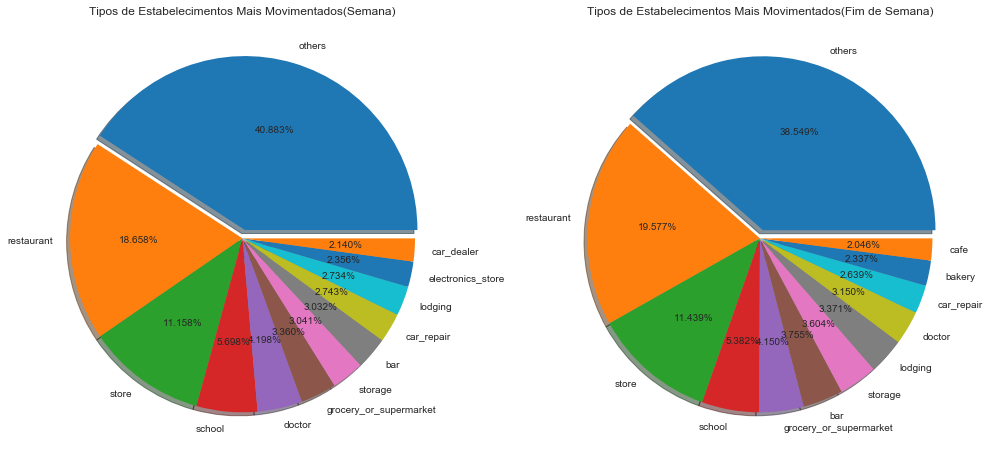

In [24]:
fig = plt.figure(figsize=(17,8))
ax1 = fig.add_subplot(121)
ax1.set_title('Tipos de Estabelecimentos Mais Movimentados(Semana)')
ax1.pie(category_week[:12], 
        labels=category_week[:12].index, 
        autopct='%.3f%%',
        explode=[0.05] + [0]*(len(category_week[:12])-1), # in case there is a unknown number of elements
        shadow=True)
ax2 = fig.add_subplot(122)
ax2.set_title('Tipos de Estabelecimentos Mais Movimentados(Fim de Semana)')
ax2.pie(category_weekend[:12], 
        labels=category_weekend[:12].index, 
        autopct='%.3f%%',
        explode=[0.05] + [0]*(len(category_weekend[:12])-1), # in case there is a unknown number of elements
        shadow=True)
plt.show()

In [25]:
group_by_week_day_category = dataset.groupby(by='day_of_week')['categoria'].value_counts()
'''
    # Método para plotar barcharts de estabelecimentos por dia da semana
'''
def barWeekDayCategories(week_days, categories, figsize):
    fig = plt.figure(figsize=figsize)
    n_lines = len(week_days)
    n_cols = 1
    for i in range(n_lines):
        ax = fig.add_subplot(str(n_lines)+str(n_cols)+str(i+1))
        for category in categories:
            ax.bar(category, group_by_week_day_category[week_days[i]][category], label=category)
        ax.legend()
    plt.show()

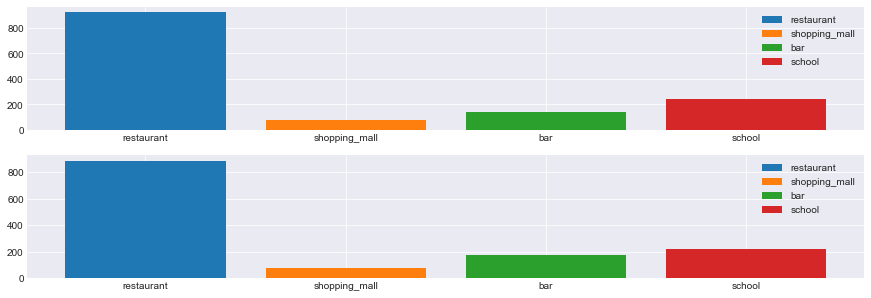

In [26]:
barWeekDayCategories(['Thursday', 'Sunday'], ['restaurant', 'shopping_mall', 'bar', 'school'], (15,5))

<p>Olhando para os gráficos anteriores podemos concluir que não há um ganho de informação muito interessante por esses gráficos, principalmente por dar a impressão de que algumas colunas são irelevantes (quando adicionamos restaurante como uma das colunas, por exemplo). Por esse motivo foi implementado o segundo método.</p>

In [27]:
group_by_category_week_day = dataset.groupby(by='categoria')['day_of_week'].value_counts()
'''
    # Método para plotar barcharts 
'''
def barWeekCategoryDays(week_days, categories, figsize):
    fig = plt.figure(figsize=figsize)
    n_lines = len(categories)
    n_cols = 1
    for i in range(n_lines):
        ax = fig.add_subplot(str(n_lines)+str(n_cols)+str(i+1))
        ax.set_title(categories[i] + ' por Dias da Semana')
        for week_day in week_days:
            ax.bar(week_day, group_by_category_week_day[categories[i]][week_day], label=week_day)
        ax.legend(bbox_to_anchor=(1.0, 1.0))
        ax.set_ylim(ymin = max(group_by_category_week_day[categories[i]].min()-50, 0))
    plt.show()

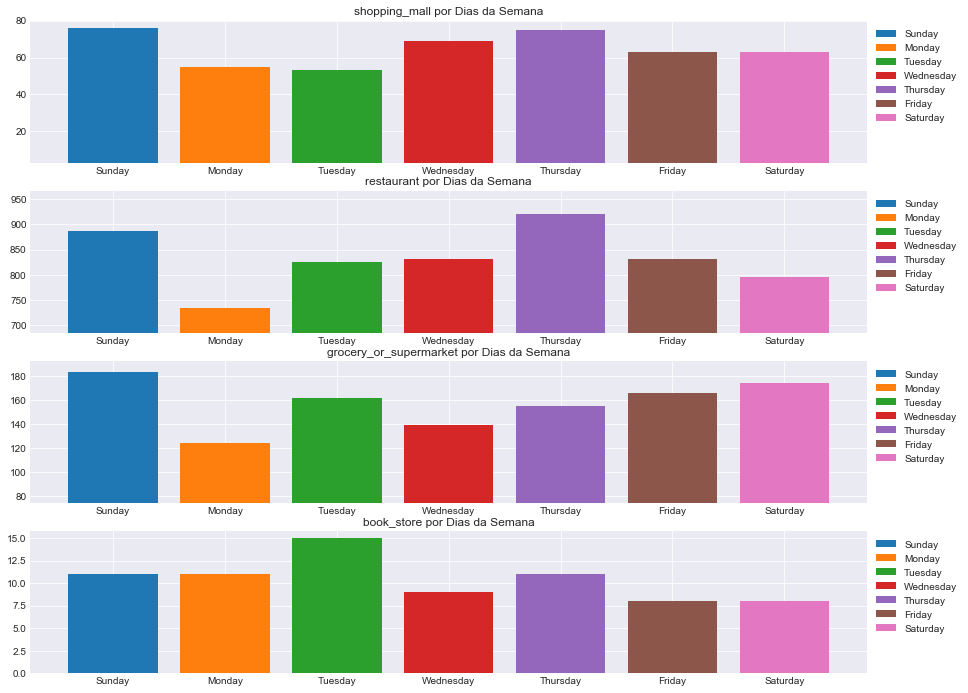

In [28]:
barWeekCategoryDays(week_days, ['shopping_mall', 'restaurant', 'grocery_or_supermarket', 'book_store'], (15,12))

<p>A partir dos gráficos acima notamos uma diferença não por contagem absoluta, mas relativa. Notamos que, quando falamos de shopping, domingo é o dia mais visitado por usuários, mesmo sendo o dia menos 'ativo'. Notamos também que domingo é o segundo dia com maior movimentação em restaurantes. Podemos concluir que, de acordo com essa base de dados e mesmo vendo domingo ser o dia com menos registro, é um dia bastante diferenciado quando falamos de shoppings e restaurante, por exemplo (principalmente quando falamos de shopping).</p>
<p>Analisando também os gráficos comparativos de mercado, notamos que os usuários preferem fazer suas compras nos finais de semana, sendo essa hora a melhor para buscar impactar clientes nesses locais.</p>

<h3>Hora x Categoria</h3>
<p>Com os métodos acima podemos analisar bem qual seria o melhor dia da semana para vincular campanhas direcionadas a um tipo de estabelecimento, nos resta agora saber em que horário seria melhor vinculado. Sabemos por cima quais os melhores horários em geral, porém podemos ir muito mais fundo.</p>

In [29]:
groupby_category_hour = dataset.groupby(by='categoria')['hour'].value_counts()
'''
    # Método para gerar lineplots do dataframe categoria x hora
    # A ideia é analisar o comportamento dos usuários por dia nesses locais
    # exemplo: shoppings são mais acessados às 13 e 19 horas
'''
def lineCategoryHour(categories, figsize):
    fig = plt.figure(figsize=figsize)
    n_lines = len(categories)
    n_cols = 1
    for i in range(n_lines):
        ax = fig.add_subplot(str(n_lines)+str(n_cols)+str(i+1))
        ax.set_title(categories[i])
        ax.plot(groupby_category_hour[categories[i]].sort_index(), label=categories[i])
        ax.set_xticks(list(range(24)))
    plt.show()

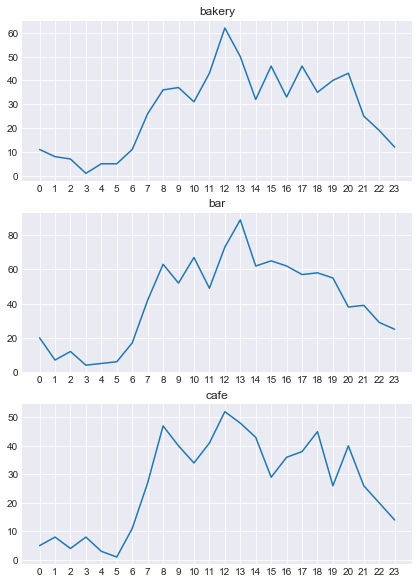

In [30]:
lineCategoryHour(['bakery', 'bar', 'cafe'], (7,10))

<p>Algumas informações já eram conhecidas (por exemplo, restaurantes tendem a possuir mais clientes no horário do almoço), porém podemos observar um comportamento mais interessante para shoppings: picos de usuário. Podemos observar uma maior movimentação em 2 horários: 13 horas e 19 horas.</p>

<h3>Dia</h3>
<p>A análise do dia que houve a visita pode não ser tão clara, talvez a análise do dia da semana traga mais informações. Porém, se temos um dia sobressalente entre os demais e foge um pouco do padrão dos dias da semana, talvez aquele dia possa ser um feriado ou um dia especial como, por exemplo, um jogo de copa do mundo.</p>

In [31]:
contagem_por_dia = dataset['dia'].value_counts().sort_index()
contagem_por_dia

01    1605
02    1875
03    2259
04    2340
05    2468
06    2253
07    2155
08    1643
09    2071
10    2218
11    2160
12    2267
13    2289
14    2032
15    1167
Name: dia, dtype: int64

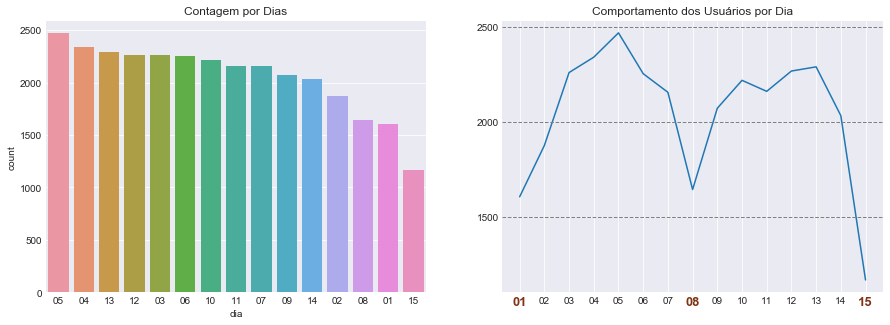

In [32]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title('Contagem por Dias')
sns.countplot(data=dataset, x='dia', order=contagem_por_dia.sort_values(ascending=False).index, ax=ax1)
ax2 = fig.add_subplot(122)
ax2.set_title('Comportamento dos Usuários por Dia')
ax2.plot(contagem_por_dia)
yticks_array = [place for place in range(1000, 3000, 500)]
ax2.set_yticks(yticks_array[1:])
for place in yticks_array[1:]:
    ax2.axhline(place, ls='--', c='gray', lw=1)
fig.canvas.draw()
for ax in ax2.get_xticklabels():
    curr_week_day = correct_day_day_of_week[ax.get_text()]
    if curr_week_day == 'Sunday':
        ax.set_color(week_days_color[curr_week_day])
        ax.set_fontsize(13)
        ax.set_fontweight('bold')
plt.show()

<p>Pelo gráfico da direita podemos ver quais os dias mais agitados do mês (até agora). Vemos que o dia 5 foi o dia mais movimentado, e essa contagem vai decrescendo suavemente até o dia 02, onde a queda foi mais brusca. Analisando o gráfico da direita podemos ver como os usuários se comporta em uma linha temporal. Notamos uma sazonalidade (os vales do gráfico estão mais ou menos separados pela mesma "distância". Notamos também o vale global do gráfico no dia 15 em ambas as tabelas e, coincidentemente, o dia 15 foi a final da copa do mundo.</p>

In [33]:
menores_dias = list(contagem_por_dia.sort_values().index)[:7]
menores_dia_da_semana = pd.Series([correct_day_day_of_week[day] for day in menores_dias]).value_counts()
menores_dia_da_semana

Sunday      3
Monday      2
Saturday    2
dtype: int64

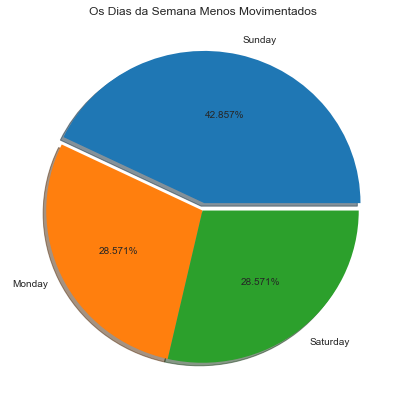

In [34]:
plt.figure(figsize=(7,7))
plt.title('Os Dias da Semana Menos Movimentados')
plt.pie(menores_dia_da_semana, 
        labels=menores_dia_da_semana.index, 
        autopct='%.3f%%',
        explode=[0.05] + [0]*(len(menores_dia_da_semana)-1), # in case there is a unknown number of elements
        shadow=True)
plt.show()

<p>Ao analisarmos os 7 "piores" dias da semana, vemos que a maioria deles é um Domingo, o que nos diz que o pior dia da semana para se vincular campanhas é neste dia pois a maioria dos consumidores se encontram mais em casa.</p>

In [35]:
category_day = dataset.groupby(by='categoria')['dia'].value_counts().sort_index()
day_category = dataset.groupby(by='dia')['categoria'].value_counts().sort_values()

In [36]:
def lineCategoryDay(categories, figsize=(10,7)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for category in categories:
        ax.plot(category_day[category], label = category)
    ax.legend()
    plt.show()

In [37]:
def barDayCategory(days, categories, figsize):
    fig = plt.figure(figsize=figsize)
    n_lines = len(days)
    n_cols = 1
    for i in range(n_lines):
        ax = fig.add_subplot(str(n_lines)+str(n_cols)+str(i+1))
        for category in categories:
            ax.bar(category, day_category[days[i]][category])
    plt.show()

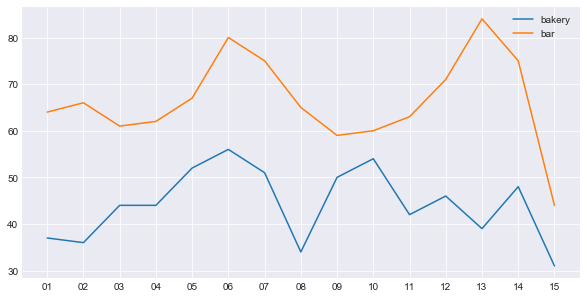

In [38]:
lineCategoryDay(categories=['bakery', 'bar'], figsize=(10,5))

<h3>Latitude e Longitude</h3>
<p>Ao utilizarmos latitude e longitude, devemos ter cuidado em como vamos imprimir um mapa a partir da base. No nosso caso, a base possui mais de 30k linhas, sendo inviável imprimir todos os pontos. Porém diversas abordagens podem ser utilizadas para nos retornar algum valor. A que usarei abaixo:</p>
<ul>
    <li>Clusters de por Característica: podemos executar o algoritmo KMeans para clusterizar os dados da base de acordo com uma característica: por exemplo, clusters de restaurantes. Dessa forma é possível achar o centro de locais com grande densidade de restaurantes e, dessa forma, tentar impactar o máximo de clientes que buscam restaurantes diariamente naquela região.</li>

In [39]:
# Method to place markers at Brazil's map
def addMarkers(coordinates):
    map_brazil = folium.Map(location=[-8.05428, -34.8813], zoom_start=4)
    for lat, lon in coordinates:
        folium.Marker([lat, lon], 
                      icon=folium.Icon(color='green'),
                      popup=str(lat) + ',' + str(lon)).add_to(map_brazil)
    return map_brazil

In [40]:
kmeans = KMeans(n_clusters=1000)

In [41]:
lat_lon_restaurant = dataset[dataset['categoria']=='restaurant'][['latitude', 'longitude']]
kmeans.fit(lat_lon_restaurant)
centers_restaurant = kmeans.cluster_centers_

In [42]:
addMarkers(centers_restaurant)

In [43]:
le = LabelEncoder()

In [44]:
dataset_2 = dataset.drop(columns=['user'])
dataset_2[['dia', 'day_of_week', 'hour', 'categoria']] = dataset_2[['dia', 'day_of_week', 'hour', 'categoria']].apply(le.fit_transform)

In [45]:
dataset_2.head()

,latitude,longitude,dia,day_of_week,hour,categoria
0,-26.489503,-49.028018,7,3,18,4
1,-14.457400,-46.433148,7,3,7,74
2,-8.903859,-36.487485,7,3,9,59
3,-22.823960,-43.012243,7,3,22,84
4,-24.949576,-53.488507,7,3,3,74


In [46]:
kmeans = KMeans(n_clusters=1000)
kmeans.fit(dataset_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=1000, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
cluster_map = pd.DataFrame()
cluster_map['index'] = dataset_2.index.values
cluster_map['cluster'] = kmeans.labels_

In [69]:
cluster = dataset_2.loc[list(cluster_map[cluster_map['cluster'] == 999].index)]
coords_cluster = list(cluster[['latitude', 'longitude']].values)

In [70]:
addMarkers(coords_cluster)

In [52]:
kmeans.cluster_centers_

array([[-23.19658782, -46.50332   ,   2.48888889,   4.35555556,
         11.64444444,  43.15555556],
       [-22.67217993, -43.26301793,   6.02222222,   1.2       ,
         14.71111111,  74.11111111],
       [-12.85575388, -38.94626265,  11.17647059,   2.91176471,
          9.29411765,  12.08823529],
       ..., 
       [-28.03064092, -50.02421038,   9.38461538,   3.23076923,
          2.        ,  28.07692308],
       [-23.23282908, -46.8839667 ,   3.36904762,   4.58333333,
         18.42857143,  73.71428571],
       [ -9.8732351 , -65.9565877 ,   4.3       ,   3.9       ,
         18.3       ,  81.7       ]])

In [79]:
dataset['user'].value_counts()[:15]

User_3822    15
User_5838    15
User_2285    15
User_5857    14
User_5180    14
User_3808    14
User_2616    14
User_787     13
User_4158    13
User_130     13
User_3983    13
User_3594    13
User_1708    13
User_317     13
User_5340    13
Name: user, dtype: int64

In [84]:
addMarkers(dataset[dataset['user'] == 'User_2285'][['latitude', 'longitude']].values)

In [101]:
coords = dataset[dataset['latitude'] == -19.833176][['latitude', 'longitude']].values

In [103]:
# dataset['latitude'].value_counts()
addMarkers(coords)

In [183]:
def setPrecision(val, decimalPlaces = 5):
    return int(val*10**decimalPlaces)/10**decimalPlaces

In [185]:
dataset['latitude'].apply(setPrecision).value_counts()

-22.90165    4
-23.54870    4
-23.51110    4
-23.52571    4
-23.57032    4
-22.90783    4
-23.54865    3
-23.50221    3
-23.54297    3
-23.54167    3
-22.90723    3
-22.92470    3
-22.88450    3
-22.90309    3
-22.85245    3
-23.57370    3
-23.59540    3
-3.77564     3
-22.88459    3
-23.62283    3
-22.90822    3
-22.89246    3
-22.90777    3
-23.53760    3
-22.90429    3
-23.66778    3
-22.90894    3
-23.51673    3
-23.54060    3
-23.56017    3
            ..
-25.48563    1
-7.02404     1
-16.57937    1
-3.08589     1
-10.94333    1
-21.67240    1
-25.54151    1
-16.02503    1
-21.19815    1
-21.37518    1
-22.90750    1
-1.42276     1
-3.73619     1
-23.44830    1
-19.94985    1
-23.69555    1
-19.86334    1
-22.29814    1
-8.06101     1
-23.53408    1
-23.53015    1
-3.77571     1
-29.77126    1
-23.57199    1
-23.69086    1
-7.99917     1
-12.71966    1
-1.33973     1
-12.76562    1
-0.03125     1
Name: latitude, Length: 29669, dtype: int64

In [189]:
dataset_3 = dataset
dataset_3[['latitude', 'longitude']] = dataset_3[['latitude', 'longitude']].applymap(setPrecision)

In [193]:
dataset_3[dataset_3['categoria'] == 'restaurant']['latitude'].value_counts()

-23.51263    3
-23.62283    2
-19.83195    2
-22.90783    2
-23.50495    2
-23.53228    2
-22.88144    2
-23.64976    2
-27.59218    2
-23.98514    2
-23.54175    2
-22.89430    2
-19.95546    2
-23.66814    2
-22.86953    2
-23.63123    2
-23.56997    2
-23.51110    2
-22.51166    2
-19.83884    2
-23.49710    2
-23.55491    2
-21.74582    2
-15.63985    2
-23.49709    2
-23.52571    2
-19.98428    2
-3.07493     2
-23.51895    2
-23.67607    2
            ..
-8.08011     1
-19.87437    1
-23.49722    1
-2.49976     1
-23.83047    1
-15.77291    1
-27.58696    1
-22.88365    1
-23.56499    1
-21.75220    1
-16.68873    1
-22.87726    1
-25.10890    1
-12.89777    1
-12.98191    1
-19.93429    1
-10.17801    1
-26.48905    1
-30.02833    1
-10.86815    1
-12.97100    1
-12.25685    1
-29.96024    1
-2.41955     1
-8.24730     1
-20.25540    1
-9.56545     1
-7.87493     1
-1.29273     1
-10.16453    1
Name: latitude, Length: 5788, dtype: int64

In [197]:
dataset_3[dataset_3['latitude'] == -23.51263][['latitude', 'longitude']].values

array([[-23.51263, -46.5501 ],
       [-23.51263, -46.18012],
       [-23.51263, -46.18852]])

In [198]:
addMarkers(dataset_3[dataset_3['latitude'] == -23.51263][['latitude', 'longitude']].values)